In [0]:
## helper.py

import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(3, 224, 224).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [12]:
!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!unzip Cat_Dog_data.zip
  
import torch
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

--2019-07-24 14:43:38--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.146.37
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.146.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip.3’

Cat_Dog_data.zip.3  100%[===================>] 553.60M  79.4MB/s    in 7.7s    

2019-07-24 14:43:46 (71.9 MB/s) - ‘Cat_Dog_data.zip.3’ saved [580495262/580495262]

Archive:  Cat_Dog_data.zip
replace Cat_Dog_data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/Cat_Dog_data/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Cat_Dog_data/test/cat/cat.7660.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/Cat_Dog_data/test/cat/._cat.7660.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Cat_Dog_data/test/cat/cat.1211.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/Cat_Do

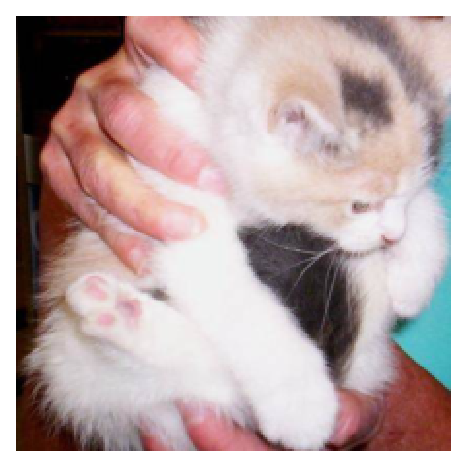

In [13]:
data_dir = 'Cat_Dog_data'
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

images, labels = next(iter(dataloader))
imshow(images[0], normalize=False)

In [0]:
train_transforms = transforms.Compose([transforms.Resize(250),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(250),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(data_dir + "/train", transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + "/test", transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

model = models.densenet121(pretrained=True)

In [0]:
for param in model.parameters():
  param.require_grad=False
  
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024,500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500,2)),
                          ('output', nn.LogSoftmax(dim=1))
                        ]))

model.classifier = classifier

In [0]:
import time

for device in ['cpu','cuda']:
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
  
  model.to(device)
  
  for ii, (images,labels) in enumerate(trainloader):
    images, labels = images.to(device) , labels.to(device)
    
    start = time.time()
    
    outputs = model.forward(images)
    loss = criterion(outputs, labels)
    loss.backward()
    
    optimizer.step()
    
    if(ii==3):
      break
    
  print(f"Device: {device} | Time per batch: {(time.time()-start)/3:.3f} seconds")

In [0]:
model = models.densenet121(pretrained=True)

for params in model.parameters():
  param.require_grad = False
  
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024,500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500,2)),
                          ('output', nn.LogSoftmax(dim=1))
                        ]))

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [0]:
epochs = 2
steps = 0
running_loss = 0
print_every = 10

In [19]:
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if (steps % print_every):
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/2.. Train loss: 0.079.. Test loss: -0.044.. Test accuracy: 0.000
Epoch 1/2.. Train loss: -0.056.. Test loss: -0.670.. Test accuracy: 0.001
Epoch 1/2.. Train loss: -0.195.. Test loss: -1.270.. Test accuracy: 0.005
Epoch 1/2.. Train loss: -0.339.. Test loss: -1.878.. Test accuracy: 0.016
Epoch 1/2.. Train loss: -0.469.. Test loss: -2.516.. Test accuracy: 0.048
Epoch 1/2.. Train loss: -0.609.. Test loss: -3.172.. Test accuracy: 0.121
Epoch 1/2.. Train loss: -0.745.. Test loss: -3.801.. Test accuracy: 0.236
Epoch 1/2.. Train loss: -0.874.. Test loss: -4.497.. Test accuracy: 0.349
Epoch 1/2.. Train loss: -1.027.. Test loss: -5.201.. Test accuracy: 0.429
Epoch 1/2.. Train loss: -2.437.. Test loss: -6.585.. Test accuracy: 0.480
Epoch 1/2.. Train loss: -1.432.. Test loss: -7.289.. Test accuracy: 0.486
Epoch 1/2.. Train loss: -1.561.. Test loss: -7.940.. Test accuracy: 0.487
Epoch 1/2.. Train loss: -1.704.. Test loss: -8.628.. Test accuracy: 0.487
Epoch 1/2.. Train loss: -1.837.. Test l

KeyboardInterrupt: ignored

In [0]:
images, lables = next(iter(testloader))
img = images[0].view(1,-1)

with torch.no_grad():
  logps = model.forward(img)
  
ps = torch.exp(logps)

imshow(images[0:,])